# Prediciendo la diabetes
## El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.

# 1.0 Importamos las librerias a utilizar

In [70]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import joblib
import os

 # 1.1 Importamos los datos

In [72]:
df = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/diabetes.csv')
pd.set_option('display.max_columns', None)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [73]:
df.shape

(768, 9)

# 2.1 Identificamos columnas con valores unicos

In [74]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
0
1
2
3
4
...
763
764
765
766


# 2.2 Eliminamos filas y columnas duplicadas

In [75]:
# Comporbar ducpliados
df.duplicated().sum()

np.int64(0)

In [76]:
df.T.duplicated().sum()

np.int64(0)

# 2.3 Identificamos columnas redundantes

Tras realizar un análisis superficial del dataset, no se identificaron columnas redundantes evidentes. Cada una de las 9 columnas representa una medida diagnóstica diferente y cumple un propósito específico en la predicción de diabetes.

# 2.4 Eliminar columnas Data leakage

En este dataset no se identificaron columnas que generen data leakage. Todas las variables predictoras representan medidas diagnósticas que se pueden obtener antes de conocer el resultado del diagnóstico de diabetes.

# 2.5 Buscamos valores faltantes

In [77]:
df.shape

(768, 9)

In [78]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

Series([], dtype: float64)

<Axes: >

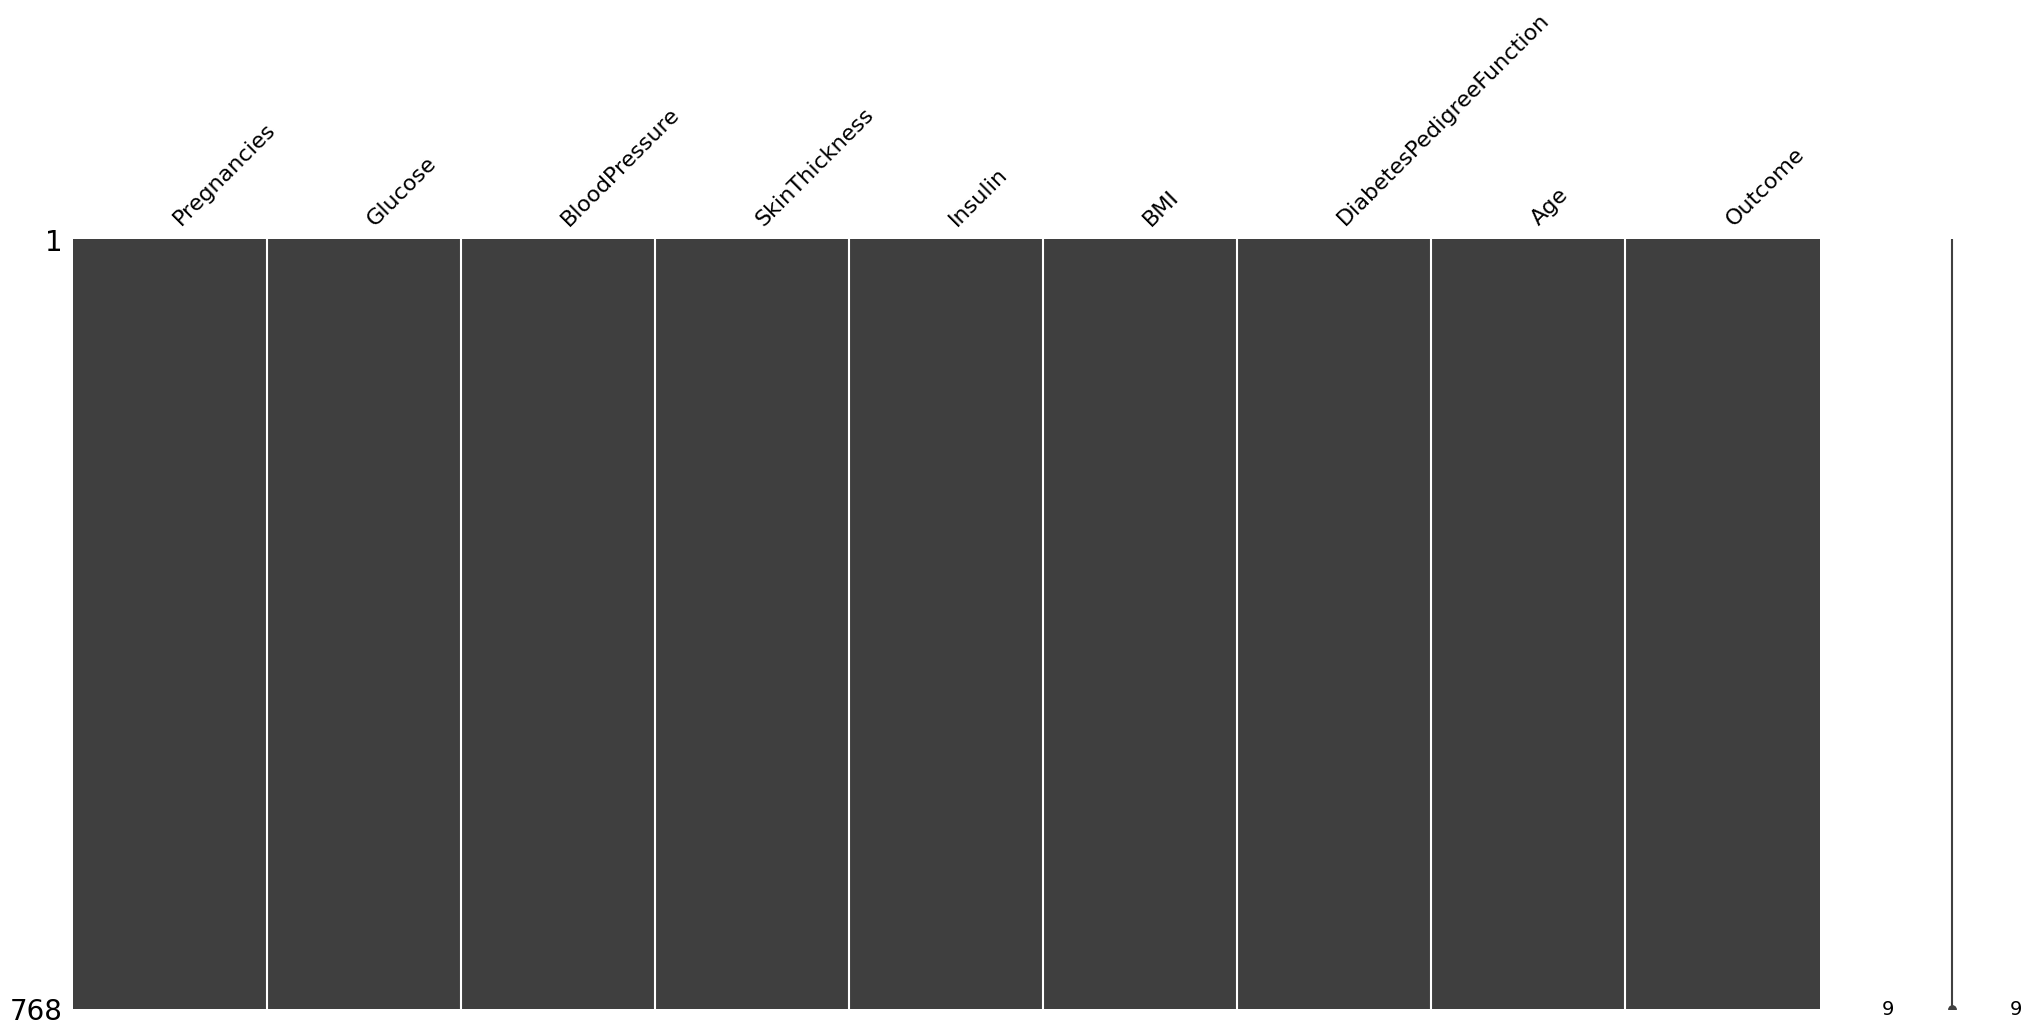

In [79]:
msno.matrix(df)

In [80]:
df.shape

(768, 9)

In [81]:
# Guardar el dataframe limpio para uso en otros modelos
os.makedirs('/workspaces/carlos060495-intro-ml/data/processed', exist_ok=True)
df.to_pickle('/workspaces/carlos060495-intro-ml/data/processed/diabetes_clean.pkl')
print("✅ Dataframe guardado exitosamente en: data/processed/diabetes_clean.pkl")
print(f"📊 Forma del dataframe: {df.shape}")

✅ Dataframe guardado exitosamente en: data/processed/diabetes_clean.pkl
📊 Forma del dataframe: (768, 9)


## No encontramos valores faltantes en el dataset.

# 3.1 Train test split

In [82]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.1 Arbol de desicion simple

In [84]:
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, random_state=42)
simple_tree.fit(X_train, y_train)

complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train, y_train)

# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

In [85]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [86]:
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.737785,0.663883,0.739823,0.597744,0.746479,0.733167
Test,0.636364,0.594203,0.660606,0.493976,0.745455,0.575758
Diferencia,0.101421,0.069680,0.079217,0.103768,0.001024,0.157410


In [87]:
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000,1.000000,1.000000
Test,0.746753,0.672269,0.742424,0.625,0.727273,0.757576
Diferencia,0.253247,0.327731,0.257576,0.375,0.272727,0.242424


In [88]:
# Matriz de confusión
cm = confusion_matrix(y_test, test_pred_simple)
cm

array([[57, 42],
       [14, 41]])

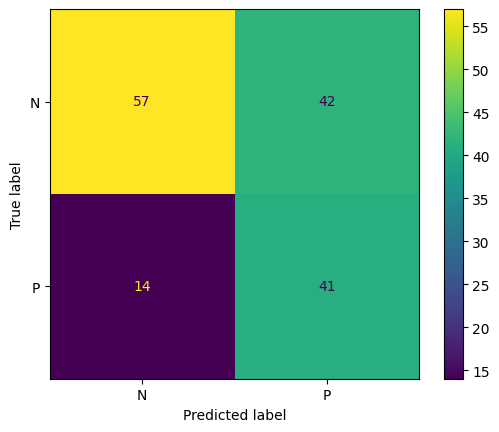

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'P'])
disp.plot()

In [90]:
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Age <= 28.50
|   |--- Glucose <= 127.50
|   |   |--- BMI <= 30.95
|   |   |   |--- class: 0
|   |   |--- BMI >  30.95
|   |   |   |--- class: 0
|   |--- Glucose >  127.50
|   |   |--- SkinThickness <= 31.50
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  31.50
|   |   |   |--- class: 1
|--- Age >  28.50
|   |--- BMI <= 27.85
|   |   |--- Glucose <= 123.00
|   |   |   |--- class: 0
|   |   |--- Glucose >  123.00
|   |   |   |--- class: 0
|   |--- BMI >  27.85
|   |   |--- Insulin <= 142.00
|   |   |   |--- class: 1
|   |   |--- Insulin >  142.00
|   |   |   |--- class: 1



# 4.2 Comparación de criterios de pureza

In [91]:
# Definir los criterios a probar
criterios = ['gini', 'entropy', 'log_loss']

# Diccionario para almacenar los modelos y resultados
resultados = {}

# Entrenar un modelo con cada criterio
for criterio in criterios:
    # Crear el modelo
    modelo = DecisionTreeClassifier(
        criterion=criterio,
        max_depth=5,
        min_samples_leaf=15,
        random_state=42
    )
    
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Guardar resultados
    resultados[criterio] = {
        'modelo': modelo,
        'train_pred': y_pred_train,
        'test_pred': y_pred_test,
        'metrics': get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    }
    
print("Modelos entrenados exitosamente para todos los criterios.")

Modelos entrenados exitosamente para todos los criterios.


In [92]:
# Mostrar las métricas de cada criterio
for criterio in criterios:
    print(f"\n{'='*60}")
    print(f"CRITERIO: {criterio.upper()}")
    print(f"{'='*60}")
    print(resultados[criterio]['metrics'])


CRITERIO: GINI
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.817590  0.730769  0.793216   0.748768  0.713615     0.872818
Test        0.759740  0.666667  0.740404   0.660714  0.672727     0.808081
Diferencia  0.057849  0.064103  0.052812   0.088054  0.040888     0.064737

CRITERIO: ENTROPY
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.815961  0.730310  0.793070   0.742718  0.718310     0.867830
Test        0.766234  0.678571  0.749495   0.666667  0.690909     0.808081
Diferencia  0.049727  0.051739  0.043575   0.076052  0.027401     0.059750

CRITERIO: LOG_LOSS
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.815961  0.730310  0.793070   0.742718  0.718310     0.867830
Test        0.766234  0.678571  0.749495   0.666667  0.690909     0.808081
Diferencia  0.049727  0.051739  0.043575   0.076052  0.027401     0.059750


In [93]:
# Crear DataFrame comparativo con métricas de test
comparacion_test = pd.DataFrame({
    'Gini': resultados['gini']['metrics'].loc['Test'],
    'Entropy': resultados['entropy']['metrics'].loc['Test'],
    'Log_Loss': resultados['log_loss']['metrics'].loc['Test']
}).T

print("Comparación de métricas en conjunto de TEST:")
print(comparacion_test)

Comparación de métricas en conjunto de TEST:
          Accuracy        F1       AUC  Precision    Recall  Specificity
Gini      0.759740  0.666667  0.740404   0.660714  0.672727     0.808081
Entropy   0.766234  0.678571  0.749495   0.666667  0.690909     0.808081
Log_Loss  0.766234  0.678571  0.749495   0.666667  0.690909     0.808081


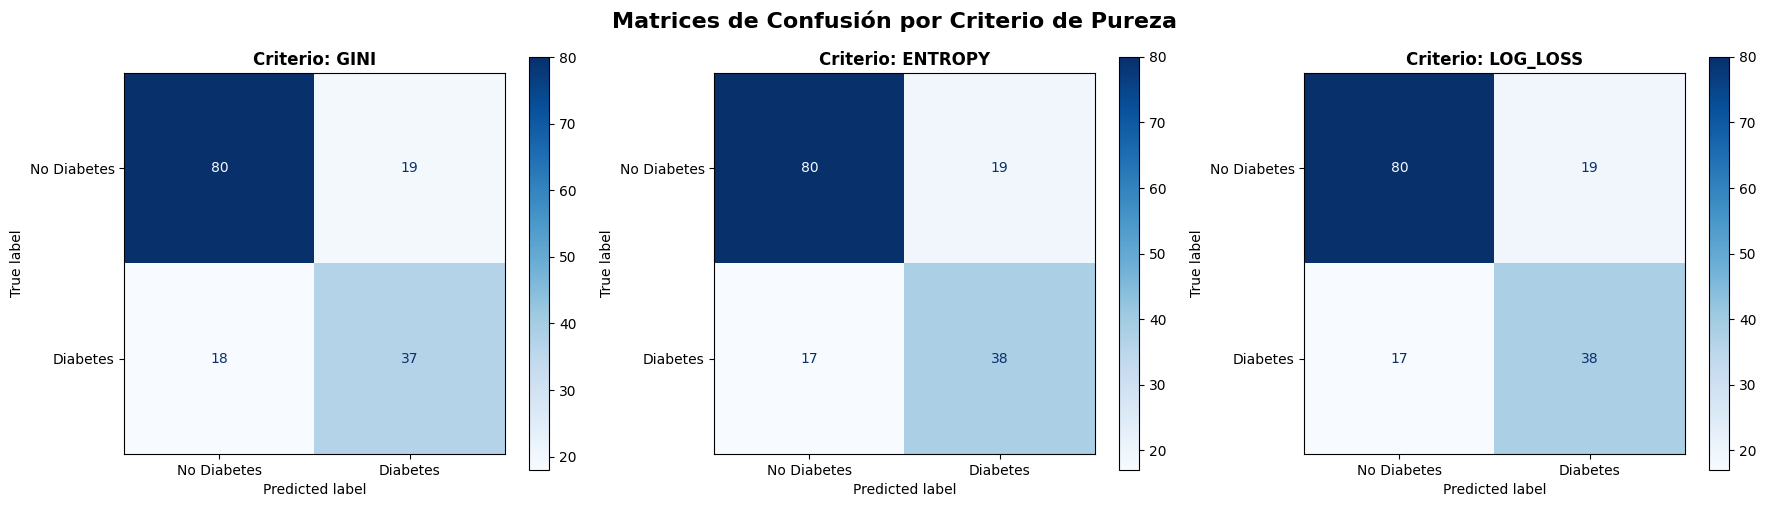

In [94]:
# Comparar matrices de confusión de los tres criterios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusión por Criterio de Pureza', fontsize=16, fontweight='bold')

for idx, criterio in enumerate(criterios):
    cm = confusion_matrix(y_test, resultados[criterio]['test_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'Criterio: {criterio.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Selección del mejor criterio
Después de analizar los resultados de los tres criterios de pureza, observamos que **Entropy y Log_Loss produjeron métricas idénticas** y superiores a Gini

Hemos seleccionado el criterio **Entropy** para nuestro modelo final de predicción de diabetes.

# 5.1 Hiperparametros

In [95]:
from sklearn.model_selection import GridSearchCV

# Definir el espacio de hiperparámetros para DecisionTreeClassifier
# Ya seleccionamos 'entropy' como mejor criterio, así que lo fijamos
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'sqrt', 'log2']
}

# Crear el modelo base con criterion='entropy'
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='f1',  # Usamos F1 por el balance entre precision y recall
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Ajustar el modelo
print("Iniciando búsqueda de hiperparámetros con criterion='entropy'...")
grid_search.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print("\n" + "="*60)
print("Mejores hiperparámetros encontrados:")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1 Score en validación cruzada: {grid_search.best_score_:.4f}")

# Guardar el mejor modelo
best_model = grid_search.best_estimator_

Iniciando búsqueda de hiperparámetros con criterion='entropy'...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, mi

[CV] END max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_depth=7, max_features=log2, min_samples_leaf=10, min_samples_split=

In [96]:
# Evaluar el mejor modelo
y_pred_train_best = best_model.predict(X_train)
y_pred_test_best = best_model.predict(X_test)

# Obtener métricas del mejor modelo
best_metrics = get_metrics(y_train, y_test, y_pred_train_best, y_pred_test_best)

print("\n" + "="*60)
print("Métricas del modelo optimizado:")
print("="*60)
print(best_metrics)


Métricas del modelo optimizado:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.853420  0.785714  0.834955   0.797101  0.774648     0.895262
Test        0.733766  0.630631  0.712121   0.625000  0.636364     0.787879
Diferencia  0.119654  0.155084  0.122834   0.172101  0.138284     0.107383


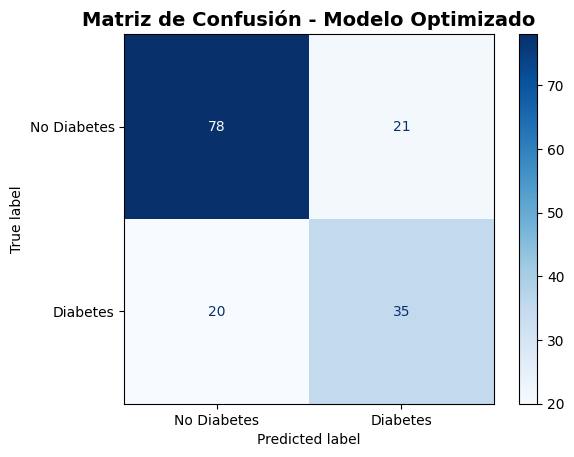

In [97]:
# Matriz de confusión del modelo optimizado
cm_best = confusion_matrix(y_test, y_pred_test_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['No Diabetes', 'Diabetes'])
disp_best.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Modelo Optimizado', fontsize=14, fontweight='bold')
plt.show()

In [98]:


# Crear directorio para modelos si no existe
model_dir = '/workspaces/carlos060495-intro-ml/models'
os.makedirs(model_dir, exist_ok=True)

# Guardar el modelo optimizado
model_path = os.path.join(model_dir, 'decision_tree_diabetes.pkl')
joblib.dump(best_model, model_path)

print(f"✅ Modelo guardado exitosamente en: {model_path}")
print(f"📊 Tamaño del archivo: {os.path.getsize(model_path) / 1024:.2f} KB")

✅ Modelo guardado exitosamente en: /workspaces/carlos060495-intro-ml/models/decision_tree_diabetes.pkl
📊 Tamaño del archivo: 6.71 KB
